In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import CIFAR10
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader
from tqdm.auto import tqdm


In [ ]:
normalize = transforms.Normalize(
    mean=[0.4914, 0.4822, 0.4465],
    std=[0.247, 0.2435, 0.2616],
)

In [ ]:
def samplers(n, split_shuffle=True, val_size=0.1):
    if split_shuffle:
        idx = torch.randperm(n, generator=torch.Generator().manual_seed(0))
    else:
        idx = torch.arange(n)
    split_idx = int((1.0 - val_size) * n)
    train_sampler = SubsetRandomSampler(idx[:split_idx])
    val_sampler = SubsetRandomSampler(idx[split_idx:])
    return train_sampler, val_sampler

In [ ]:
def train_val_dataloader(root_dir='./cifar10', split_shuffle=True, val_size=0.1, batch_size=128):
    train_dataset = CIFAR10(root=root_dir, train=True, download=True, transform=transforms.Compose([transforms.ToTensor(), normalize]))
    val_dataset = CIFAR10(root=root_dir, train=True, download=True, transform=transforms.Compose([transforms.ToTensor(), normalize]))

    
    train_sampler, val_sampler = samplers(len(train_dataset), split_shuffle, val_size)
    train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=batch_size)
    val_dataloader = DataLoader(val_dataset, sampler=val_sampler, batch_size=batch_size)
    return train_dataloader, val_dataloader


In [ ]:
def test_dataloader(root_dir='./cifar10', batch_size=128):
    test_dataset = CIFAR10(root=root_dir, train=False, download=True, transform=transforms.Compose([transforms.ToTensor(), normalize]))
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size)
    return test_dataloader

In [ ]:
# For testing
class LeNet(nn.Module):
    def __init__(self, num_classes=10):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)

    def forward(self, x):
        out = F.relu(self.conv1(x))
        out = F.max_pool2d(out, 2)
        out = F.relu(self.conv2(out))
        out = F.max_pool2d(out, 2)
        out = out.view(out.size(0), -1)
        out = F.relu(self.fc1(out))
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        return out 

In [ ]:
def train_batch(model, x_batch, y_batch, loss_fn, optimizer):
    model.train()
    model.zero_grad()
    output = model(x_batch)
    loss = loss_fn(output, y_batch)
    loss.backward()
    optimizer.step()
    batch_loss = loss.cpu().item()
    with torch.no_grad():
        batch_acc_sum = (output.argmax(dim=1) == y_batch).sum().cpu().item()
    return batch_loss, batch_acc_sum


In [ ]:
def train_epoch(model, dataloader, loss_fn, optimizer):
    epoch_loss = 0.0
    epoch_acc = 0
    epoch_size = 0
    for i_batch, (X_batch, y_batch) in enumerate(dataloader):
        batch_loss, batch_acc_sum = train_batch(model, X_batch.to(model.device), y_batch.to(model.device), loss_fn, optimizer)
        epoch_size += len(X_batch)
        epoch_loss += batch_loss * len(X_batch)
        epoch_acc += batch_acc_sum
    epoch_loss /= epoch_size
    epoch_acc /= epoch_size
    return epoch_loss, epoch_acc


In [ ]:
def train_full(model, train_dataloader, val_dataloader, loss_fn, optimizer, n_epochs, callback=None):
    epochs = tqdm(range(n_epochs), desc='Epochs', leave=True)
    for i_epoch in epochs:
        epoch_loss, epoch_acc = train_epoch(model, train_dataloader, loss_fn, optimizer)
        if callback is not None:
            cb_dict = callback(model, val_dataloader, loss_fn, epoch_loss, epoch_acc)
            epochs.set_postfix(cb_dict)

In [ ]:
def evaluate(model, dataloader, loss_fn):
    model.eval()
    logits = []
    targets = []
    with torch.no_grad():
        for X_batch, y_batch in dataloader:
            output = model(X_batch.to(model.device)).cpu()
            logits.append(output)
            targets.append(y_batch)
    logits = torch.cat(logits)
    targets = torch.cat(targets)
    loss = loss_fn(logits, targets).item()
    acc = (logits.argmax(dim=1) == targets).sum().item() / len(targets)
    return loss, acc


In [ ]:
class CallBack:
    def __init__(self, eval_fn, name=None):
        self.eval_fn = eval_fn
        self.train_losses = []
        self.train_accs = []
        self.val_losses = []
        self.val_accs = []
    
    def last_info(self):
        return {'loss_train': f'{self.train_losses[-1]}',
                'acc_train': f'{self.train_accs[-1]}',
                'loss_val': f'{self.val_losses[-1]}',
                'acc_val': f'{self.val_accs[-1]}'}

    def __call__(self, model, val_dataloader, loss_fn,
                 epoch_loss=None, epoch_acc=None):
        self.train_losses.append(epoch_loss)
        self.train_accs.append(epoch_acc)
        loss_val, acc_val = self.eval_fn(model, val_dataloader, loss_fn)
        self.val_losses.append(loss_val)
        self.val_accs.append(acc_val)
        return self.last_info()

In [ ]:
train_dataloader, val_dataloader = train_val_dataloader()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./cifar10/cifar-10-python.tar.gz to ./cifar10
Files already downloaded and verified


In [ ]:
test_loader = test_dataloader()

Files already downloaded and verified


In [ ]:
device

device(type='cuda')

In [ ]:
#ResNet
#source: https://github.com/soapisnotfat/pytorch-cifar10/blob/master/models/ResNet.py
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, activation, stride=1):
        self.activation = activation
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = self.activation(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = self.activation(out)
        return out

In [ ]:
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, activation, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64
        self.activation = activation
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)


    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, self.activation, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.activation(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


In [ ]:
def ResNet18(activation):
    return ResNet(BasicBlock, [2, 2, 2, 2], activation)

In [ ]:
def pipeline(activation_set, optimizer_set, lr):
    if activation_set == 'ReLU':
        activation = F.relu
    elif activation_set == 'LeakyReLU':
        activation = F.leaky_relu
    model = ResNet18(activation)
    model.to(device)
    model.device = device
    loss_fn = nn.CrossEntropyLoss()
    if optimizer_set == 'Adam':
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    elif optimizer_set == 'SGD':
        optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    
    cb = CallBack(evaluate)
    train_full(model, train_dataloader, val_dataloader, loss_fn, optimizer, n_epochs=30, callback=cb)
    
    loss, acc = evaluate(model, val_dataloader, loss_fn)
    return acc
    

In [ ]:
!pip install optuna

In [ ]:
import optuna
optuna.logging.set_verbosity(optuna.logging.ERROR)

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

# CMA-ES

In [ ]:
def objective(trial):

    lr = trial.suggest_float('lr', 1e-3, 1e-1, log=True)
    optimizer_set = trial.suggest_categorical('optimizer', ['Adam', 'SGD'])
    
    activation_set = trial.suggest_categorical('activation', ['ReLU', 'LeakyReLU'])
    return pipeline(activation_set, optimizer_set, lr)

In [ ]:
%%time
study = optuna.create_study(direction='maximize', sampler=optuna.samplers.CmaEsSampler())
study.optimize(objective, n_trials=12)

Epochs:   0%|          | 0/30 [00:00<?, ?it/s]

Epochs:   0%|          | 0/30 [00:00<?, ?it/s]

Epochs:   0%|          | 0/30 [00:00<?, ?it/s]

Epochs:   0%|          | 0/30 [00:00<?, ?it/s]

Epochs:   0%|          | 0/30 [00:00<?, ?it/s]

Epochs:   0%|          | 0/30 [00:00<?, ?it/s]

Epochs:   0%|          | 0/30 [00:00<?, ?it/s]

Epochs:   0%|          | 0/30 [00:00<?, ?it/s]

Epochs:   0%|          | 0/30 [00:00<?, ?it/s]

Epochs:   0%|          | 0/30 [00:00<?, ?it/s]

Epochs:   0%|          | 0/30 [00:00<?, ?it/s]

Epochs:   0%|          | 0/30 [00:00<?, ?it/s]

CPU times: user 4h 13min, sys: 18.8 s, total: 4h 13min 18s
Wall time: 4h 14min 18s


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  


<Figure size 1440x1296 with 0 Axes>

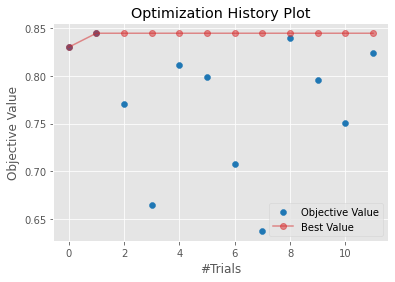

In [ ]:
plt.figure(figsize=(20, 18))
optuna.visualization.matplotlib.plot_optimization_history(study)
plt.savefig('ResNet_CMAES_HIST.pdf')

In [ ]:
print('ResNet, CMA-ES, best trial:')
print(study.best_trial.params)
print('ResNet, CMA-ES, best accuracy:')
print(study.best_value)
print('ResNet, CMA-ES, best trial number')
print(study.best_trial.number)

ResNet, CMA-ES, best trial:
{'lr': 0.0010208052058606053, 'optimizer': 'Adam', 'activation': 'LeakyReLU'}
ResNet, CMA-ES, best accuracy:
0.8446
ResNet, CMA-ES, best trial number
1


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: ExperimentalWarning: plot_contour is experimental (supported from v2.2.0). The interface can change in the future.
  


<Figure size 1440x1296 with 0 Axes>

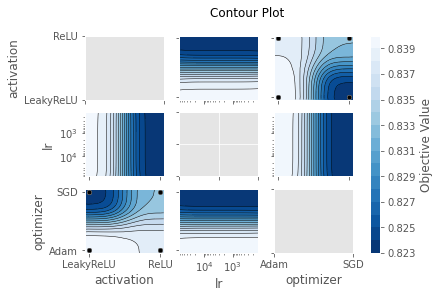

In [ ]:
plt.figure(figsize=(20, 18))
optuna.visualization.matplotlib.plot_contour(study, params=["lr", "optimizer", "activation"])
plt.savefig('ResNet_CMAES_CP.pdf')

In [ ]:
def eval_test(study):
    lr = study.best_trial.params['lr']
    if study.best_trial.params['activation'] == 'ReLU':
        activation = F.relu
    elif study.best_trial.params['activation'] == 'LeakyReLU':
        activation = F.leaky_relu

    model = ResNet18(activation)
    model.to(device)
    model.device = device
    loss_fn = nn.CrossEntropyLoss()
    cb = CallBack(evaluate)

    if study.best_trial.params['optimizer'] == 'Adam':
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    elif study.best_trial.params['optimizer'] == 'SGD':
        optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    
    train_full(model, train_dataloader, val_dataloader, loss_fn, optimizer, n_epochs=30, callback=cb)
    
    return evaluate(model, test_loader, loss_fn)

In [ ]:
loss, acc = eval_test(study)
print('ResNet, CMA-ES, accuracy on test:')
print(acc)

Epochs:   0%|          | 0/30 [00:00<?, ?it/s]

ResNet, CMA-ES, accuracy on test:
0.8404


# Grid search

In [ ]:
def objective_gs(trial):

    lr = trial.suggest_float('lr', 1e-3, 1e-1)
    optimizer_set = trial.suggest_categorical('optimizer', ['Adam', 'SGD'])

    
    activation_set = trial.suggest_categorical('activation', ['ReLU', 'LeakyReLU'])
    return pipeline(activation_set, optimizer_set, lr)

In [ ]:
%%time
search_space = {'optimizer': ['Adam', 'SGD'], 'activation': ['ReLU', 'LeakyReLU'], 'lr': np.logspace(-3, -1, 3)}
study = optuna.create_study(direction='maximize', sampler=optuna.samplers.GridSampler(search_space))
study.optimize(objective_gs, n_trials=12)

Epochs:   0%|          | 0/30 [00:00<?, ?it/s]

Epochs:   0%|          | 0/30 [00:00<?, ?it/s]

Epochs:   0%|          | 0/30 [00:00<?, ?it/s]

Epochs:   0%|          | 0/30 [00:00<?, ?it/s]

Epochs:   0%|          | 0/30 [00:00<?, ?it/s]

Epochs:   0%|          | 0/30 [00:00<?, ?it/s]

Epochs:   0%|          | 0/30 [00:00<?, ?it/s]

Epochs:   0%|          | 0/30 [00:00<?, ?it/s]

Epochs:   0%|          | 0/30 [00:00<?, ?it/s]

Epochs:   0%|          | 0/30 [00:00<?, ?it/s]

Epochs:   0%|          | 0/30 [00:00<?, ?it/s]

Epochs:   0%|          | 0/30 [00:00<?, ?it/s]

CPU times: user 4h 16min 6s, sys: 20.4 s, total: 4h 16min 27s
Wall time: 4h 17min 36s


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  


<Figure size 1440x1296 with 0 Axes>

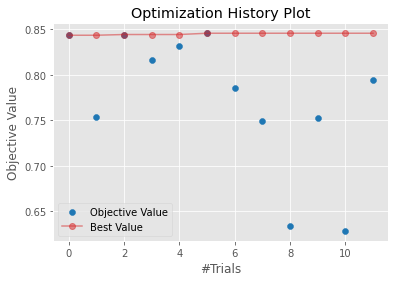

In [ ]:
plt.figure(figsize=(20, 18))
optuna.visualization.matplotlib.plot_optimization_history(study)
plt.savefig('ResNet_GS_HIST.pdf')

In [ ]:
print('ResNet, GS, best trial:')
print(study.best_trial.params)
print('ResNet, GS, best accuracy:')
print(study.best_value)
print('ResNet, GS, best trial number')
print(study.best_trial.number)

ResNet, GS, best trial:
{'lr': 0.1, 'optimizer': 'SGD', 'activation': 'ReLU'}
ResNet, GS, best accuracy:
0.8458
ResNet, GS, best trial number
5


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: ExperimentalWarning: plot_contour is experimental (supported from v2.2.0). The interface can change in the future.
  


<Figure size 1440x1296 with 0 Axes>

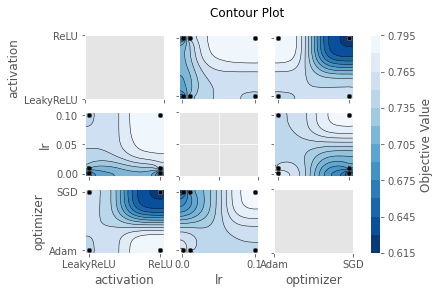

In [ ]:
plt.figure(figsize=(20, 18))
optuna.visualization.matplotlib.plot_contour(study, params=["lr", "optimizer", "activation"])
plt.savefig('ResNet_GS_CP.pdf')

In [ ]:
loss, acc = eval_test(study)
print('ResNet, GS, accuracy on test:')
print(acc)

Epochs:   0%|          | 0/30 [00:00<?, ?it/s]

ResNet, GS, accuracy on test:
0.8368
